***Project 1 - Part 1
Logan Wilson, Luca Colombo***

In [20]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import json

class BabyNames(object):
    """Class for analysis of babynames dataset"""
    
    def __init__(self, fileloc):
        """Import dataset file into dataframe"""
        self.fileloc = fileloc
        
        files = [x for x in os.listdir(self.fileloc) if 'pdf' not in x and x != '.DS_Store']
        newlist = []
        columns = ['state','sex','year','name','births']
        for file in files:
            path = '{}/{}'.format(self.fileloc, file)
            df = pd.read_csv(path,names=columns)
            newlist.append(df)
        self.data = pd.concat(newlist,ignore_index = True)
        
        self.states_list = [file[:2] for file in files]
        self.years_list = self.data.year.unique()
        
        def add_prop(group):
            """Proportion of births of given group over all births"""
            group['prop'] = round(100.0*group.births / group.births.sum(), 4)
            return group
        self.grouped_data =self.data.groupby(["name","year"],as_index=False).sum().groupby('year').apply(add_prop)
        
        self.us_states = {'AK': 'Alaska',
                     'AL': 'Alabama',
                     'AR': 'Arkansas',
                     'AZ': 'Arizona',
                     'CA': 'California',
                     'CO': 'Colorado',
                     'CT': 'Connecticut',
                     'DC': 'District of Columbia',
                     'DE': 'Delaware',
                     'FL': 'Florida',
                     'GA': 'Georgia',
                     'HI': 'Hawaii',
                     'IA': 'Iowa',
                     'ID': 'Idaho',
                     'IL': 'Illinois',
                     'IN': 'Indiana',
                     'KS': 'Kansas',
                     'KY': 'Kentucky',
                     'LA': 'Louisiana',
                     'MA': 'Massachusetts',
                     'MD': 'Maryland',
                     'ME': 'Maine',
                     'MI': 'Michigan',
                     'MN': 'Minnesota',
                     'MO': 'Missouri',
                     'MS': 'Mississippi',
                     'MT': 'Montana',
                     'NC': 'North Carolina',
                     'ND': 'North Dakota',
                     'NE': 'Nebraska',
                     'NH': 'New Hampshire',
                     'NJ': 'New Jersey',
                     'NM': 'New Mexico',
                     'NV': 'Nevada',
                     'NY': 'New York',
                     'OH': 'Ohio',
                     'OK': 'Oklahoma',
                     'OR': 'Oregon',
                     'PA': 'Pennsylvania',
                     'RI': 'Rhode Island',
                     'SC': 'South Carolina',
                     'SD': 'South Dakota',
                     'TN': 'Tennessee',
                     'TX': 'Texas',
                     'UT': 'Utah',
                     'VA': 'Virginia',
                     'VT': 'Vermont',
                     'WA': 'Washington',
                     'WI': 'Wisconsin',
                     'WV': 'West Virginia',
                     'WY': 'Wyoming'}
      
    def Count(self,state=None,year=None) :
        """Return count of baby names for given state and year"""
        s= self.data
        if state is not None :
            s = s[s.state == state]
        if year is not None :
            s = s[s.year == year]
        return s.births.sum()
    
    def Top10BabyNames(self, state='', year=''):
        """Return top 10 baby names for given state and year"""
        def get_top10(group):
            return group.sort_values(by='births',ascending=False).head(10)
        state = self.states_list if state == '' else [state]
        year = self.years_list if year == '' else [year]
        df = self.data[self.data["state"].isin(state) & 
                self.data["year"].isin(year)][["name", "births", "sex"]
                                             ].groupby(["name", "sex"], as_index = False
                                                      ).sum().groupby("sex", as_index = False
                                                                     ).apply(get_top10)[["name","sex"]]
        df["Rank"] = list(range(1,11))*2
        df = df.pivot(index = "Rank", columns = "sex", values = "name").reset_index()
        result = pd.DataFrame({"Rank" : df.Rank, "Male" : df.M, "Female" : df.F})[["Rank", "Male", "Female"]]
        return result
    
    def ChangeOfPopularity(self, fromYear=2014, toYear=2015, top=10):
        """Lists how names in given date range changed in popularity (if at all)"""
        def get_top(group):
            return group.sort_values(by=toYear,ascending=False).head(top)
        def add_prop(group):
            group['prop'] = round(100.0*group.births / group.births.sum(), 4)
            return group
        
        df = self.data[(self.data["year"] == fromYear) | (self.data["year"] == toYear)
                      ].groupby(["name", "year"], as_index = False).sum().groupby("year", 
                                                                                  as_index = False).apply(add_prop)
        df = df.pivot(index = "name", columns = "year", values = "prop").fillna(0).reset_index()

        df["delta"] = df[toYear] - df[fromYear]
        df["sign"] = "neg" 
        df.loc[(df.delta>0),"sign"] = "pos"
        df.loc[(df.delta==0),"sign"] = "zero"
        df = df.groupby("sign").apply(get_top)[["sign", "name", toYear]].reset_index(drop = True)
        df["Rank"] = list(range(1,top+1))*3

        df = df.pivot(index = "Rank", columns="sign", values = "name")
        result = pd.DataFrame({"c1" : df.pos, "c2" : df.neg, "c3" : df.zero}
                             ).rename(columns={"c1": "More popular", "c2" : "Less popular", "c3" : "Same popularity"})
        return result
    
    
    def Top5NamesPerYear(self,year=2015,sex=''):
        """Returns the five most frequent names, by State, for male, female, or both in a given year"""
        sex = ["M", "F"] if sex == '' else [sex]
        year = self.years_list if year == '' else [year]
        
        cols = ["State"]
        for x in range(1,6):
            cols.append("Rank {}".format(x))
            cols.append("Num")
        top5df = pd.DataFrame(columns=cols, index=range(51))

        for i in range(len(self.states_list)):
            df = self.data[(self.data["year"].isin(year)) & (self.data["sex"].isin(sex)) & 
                          (self.data["state"]==self.states_list[i])
                          ].sort_values(by="births", ascending = False).head(5).reset_index(drop = True)

            top5df.iloc[i,0] = self.us_states[self.states_list[i]]
            for x in range(5):
                top5df.iloc[i,x*2+1] = df.iloc[x,3]
                top5df.iloc[i,x*2+2] = df.iloc[x,4]
        return top5df
    
    def NamePopularityPlot(self, name='Jim', yearRange=(2000,2015), state='all', sex='both'):
        """Plots changes in popularity for a given name of a given sex in a given state over a given date range"""
        def add_prop(group):
            group['prop'] = round(100.0*group.births / group.births.sum(), 4)
            return group
        df =self.data
        if state != "all" :
            df = df[df.state==state]
        if sex != "both" :
            df = df[df.sex==sex]
        df = df.groupby(["name","year"],as_index=False).sum()
        df = df.groupby('year').apply(add_prop)
        df = df[(df["year"]>=yearRange[0]) & (df["year"]<=yearRange[1]) & (df["name"] == name)]
        t = "Popularity of name {} from {} to {}".format(name, yearRange[0], yearRange[1])
        df.set_index("year")["prop"].plot(title=t,figsize=(12,6))
        
    def NameJump(self, name="Bill", year=2000, state='all',sex='both') :
        """For a given name and year, returns the change in popularity in the subsequent year"""
        def add_prop(group):
            group['prop'] = round(100.0*group.births / group.births.sum(), 4)
            return group
        if state != "all" or sex != "both" :
            df =self.data
            if state != "all" :
                df = df[df.state==state]
            if sex != "both" :
                df = df[df.sex==sex]
            df = df.groupby(["name","year"],as_index=False).sum()
            df = df.groupby('year').apply(add_prop)
        else :
            df = self.grouped_data
        df = df[((df["year"]==year) | (df["year"]==year+1)) & (df["name"] == name)]
        return df.iloc[1].prop - df.iloc[0].prop
        
    def NameFlip(self, n=10):
        """For every name in every year, measure the delta between female and male numbers 
        (positive delta indicates female prevalence). Then for every name, take the difference of the maximum and
        minimum delta over all years. Plot names with the largest difference."""
        dfy = self.data.groupby(['name', 'year', 'sex'], as_index = False).sum().pivot_table(values = "births", columns = "sex", index = ["name", "year"]).fillna(0).reset_index()
        dfy["delta"] = dfy.F - dfy.M
        dfy["tot"] = dfy.F + dfy.M

        df = dfy[['name', 'delta', 'tot']].groupby("name").agg(["max", "min", "sum"]).reset_index()
        df["check"] = 0
        df.loc[(df["delta", "max"] > 0) & (df["delta", "min"] < 0), "check"] = 1

        result = pd.merge(pd.DataFrame(df[df.check == 1].sort_values([("tot", "sum")], ascending = False).head(n)["name"]),
                          dfy[["name", "year", "delta"]], left_on='name', right_on='name' , how='inner', sort=False)

        result = result.pivot(index = "year", columns = "name", values = "delta").fillna(0)
        t = "Top {} names that flipped over the years".format(n)
        result.plot(title=t,figsize=(12,6))


Test babynames class

In [21]:
s=BabyNames('namesbystate')

In [22]:
s.Count(state="CA", year=1995)

494559

In [23]:
s.Top10BabyNames(year = [1991, 1992], state = "MI")

,Rank,Male,Female
0,1,Michael,Ashley
1,2,Joshua,Jessica
2,3,Matthew,Samantha
3,4,Christopher,Amanda
4,5,Jacob,Sarah
5,6,Andrew,Brittany
6,7,Tyler,Emily
7,8,Nicholas,Chelsea
8,9,Brandon,Megan
9,10,Ryan,Rachel


In [24]:
s.ChangeOfPopularity(fromYear = 2013, toYear = 2016, top = 6)

,More popular,Less popular,Same popularity
Rank,,,
1,Olivia,Emma,Melanie
2,Noah,Liam,Deacon
3,Ava,Sophia,Niko
4,James,William,Jaylene
5,Benjamin,Mason,Carolyn
6,Mia,Isabella,Abrielle


In [25]:
s.Top5NamesPerYear(year = 1991, sex = "F").sample(4)

,State,Rank 1,Num,Rank 2,Num,Rank 3,Num,Rank 4,Num,Rank 5,Num
10,Georgia,Ashley,1471,Jessica,1253,Brittany,1125,Kayla,662,Jasmine,633
6,Connecticut,Ashley,506,Jessica,486,Amanda,430,Sarah,392,Samantha,377
25,Mississippi,Ashley,480,Brittany,421,Jessica,392,Jasmine,306,Kayla,284
32,New Mexico,Ashley,303,Amanda,224,Jessica,211,Samantha,157,Stephanie,137


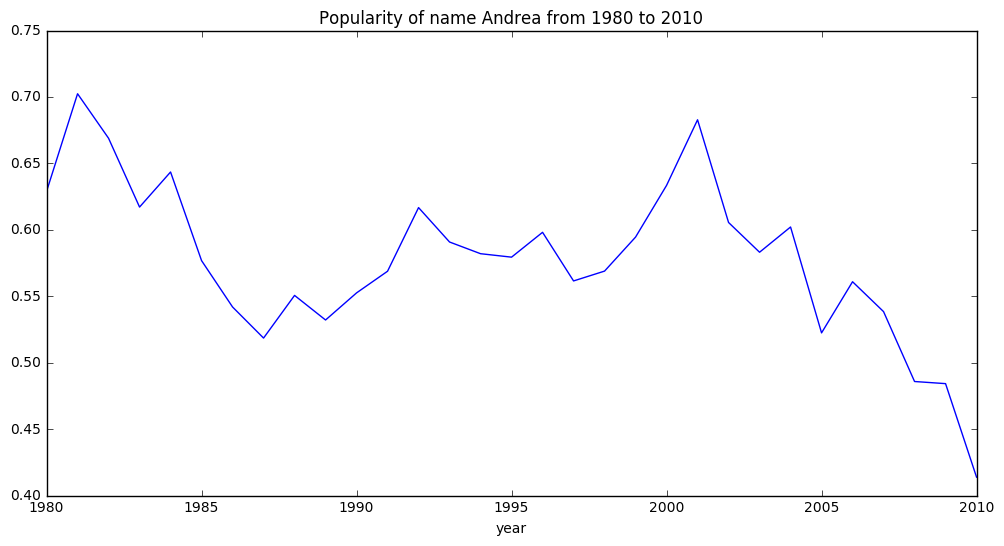

In [26]:
s.NamePopularityPlot(name = "Andrea", yearRange=(1980,2010), state = "CA", sex = "F")

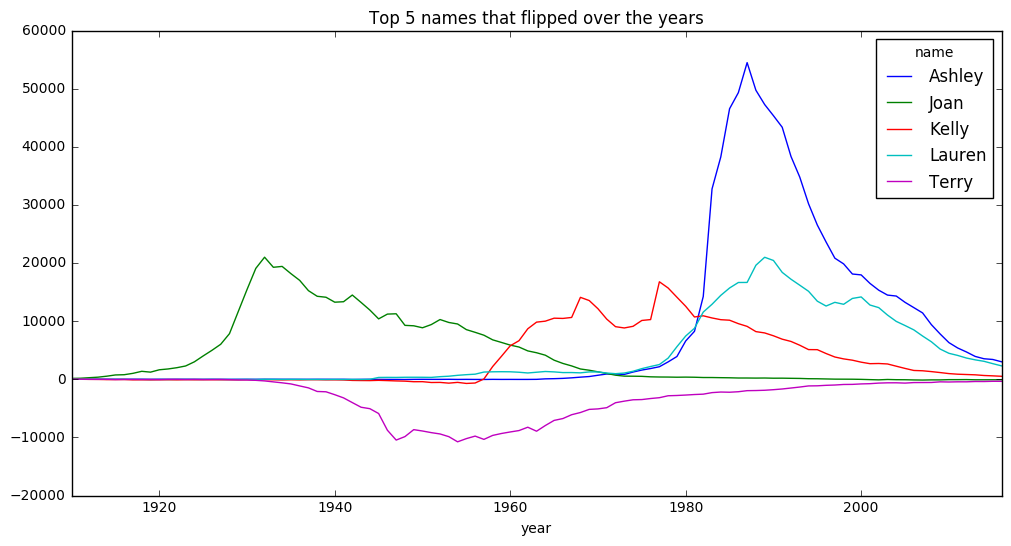

In [27]:
s.NameFlip(5)

To test our class, we examined how a change in popularity for a given name could be correlated with the release of a film featuring a main character with that name. We used data from The Movie Database, downloaded from kaggle: https://www.kaggle.com/tmdb/tmdb-movie-metadata

In [28]:
#Import and merge data
movies = pd.read_csv("tmdb_5000_movies.csv")
credits = pd.read_csv("tmdb_5000_credits.csv")
m=movies.merge(credits.drop("title",axis=1), right_on="movie_id", left_on= "id")[["title","release_date","cast"]]

def mainchar1(castlist) :
    """Return first name of character with top billing in movie credits"""
    try : 
        return json.loads(castlist)[0]['character'].split()[0]
    except :
        return np.nan
    
def mainchar2(castlist) :
    """Return first name of character with secondary billing in movie credits"""
    try : 
        return json.loads(castlist)[1]['character'].split()[0]
    except :
        return np.nan
    
def MovieJump(name, year, babynames) :
    """Apply babynames method NameJump to given name and year to measure increase in popularity 
    for given name in year immediately following the film's release"""
    try :
        return babynames.NameJump(name=name, year=year)
    except :
        return np.nan

m['char1'] = m.cast.apply(mainchar1)
m['char2'] = m.cast.apply(mainchar2)
m.release_date = pd.to_datetime(m.release_date).apply(lambda x : x.year)
m['char1_jump'] = np.vectorize(MovieJump)(m.char1,m.release_date, s)
m['char2_jump'] = np.vectorize(MovieJump)(m.char2,m.release_date, s)

We can view the top 10 movies with an increase in popularity for either main character or secondary character. However, many of these are almost certainly spurious correlations - for example, it is obviously coincidental that the movie "The Evil Dead" was released in the same year that the name "Ashley" became incredibly popular. The more appropriate correlations would likely arise from blockbuster movies featuring characters with slightly uncommon names - for example, Isabella in "Twilight," or Logan in "X-Men."

In [29]:
m.sort_values('char1_jump', ascending=False).iloc[:10]

,title,release_date,cast,char1,char2,char1_jump,char2_jump
4595,The Evil Dead,1981.0,"[{""cast_id"": 16, ""character"": ""Ashley 'Ash' J....",Ashley,Cheryl,0.1821,-0.0088
3908,Torn Curtain,1966.0,"[{""cast_id"": 2, ""character"": ""Michael Armstron...",Michael,Sarah,0.1424,0.0064
1337,Twilight,2008.0,"[{""cast_id"": 4, ""character"": ""Isabella 'Bella'...",Isabella,Edward,0.1322,0.0088
446,Con Air,1997.0,"[{""cast_id"": 1, ""character"": ""Cameron Poe"", ""c...",Cameron,Marshal,0.1186,0.0000
2586,Firestarter,1984.0,"[{""cast_id"": 1, ""character"": ""Andrew 'Andy' Mc...",Andrew,Charlene,0.1153,-0.0015
2387,Day of the Dead,1985.0,"[{""cast_id"": 1, ""character"": ""Sarah"", ""credit_...",Sarah,John,0.1064,-0.0354
1045,The Princess Diaries 2: Royal Engagement,2004.0,"[{""cast_id"": 1, ""character"": ""Mia Thermopolis""...",Mia,Queen,0.1036,-0.0004
3873,Class of 1984,1982.0,"[{""cast_id"": 1, ""character"": ""Andrew Norris"", ...",Andrew,Diane,0.0962,0.0014
213,Mission: Impossible II,2000.0,"[{""cast_id"": 31, ""character"": ""Ethan Hunt"", ""c...",Ethan,Sean,0.0906,0.0000
1564,Legends of the Fall,1994.0,"[{""cast_id"": 17, ""character"": ""Tristan Ludlow""...",Tristan,Col.,0.0873,NaN


In [30]:
m.sort_values('char2_jump', ascending=False).iloc[:10]

,title,release_date,cast,char1,char2,char1_jump,char2_jump
4144,The Lady from Shanghai,1947.0,"[{""cast_id"": 4, ""character"": ""Elsa Bannister"",...",Elsa,Michael,0.0002,0.1295
3439,The Terminator,1984.0,"[{""cast_id"": 26, ""character"": ""The Terminator""...",The,Kyle,NaN,0.1163
511,X-Men,2000.0,"[{""cast_id"": 5, ""character"": ""Charles Xavier /...",Charles,Logan,-0.0043,0.0975
3764,Topaz,1969.0,"[{""cast_id"": 1, ""character"": ""Andr\u00e9 Dever...",André,Nicole,NaN,0.0963
3531,High Plains Drifter,1973.0,"[{""cast_id"": 1, ""character"": ""The Stranger"", ""...",The,Sarah,NaN,0.0911
1135,Lord of War,2005.0,"[{""cast_id"": 1, ""character"": ""Yuri Orlov"", ""cr...",Yuri,Ava,0.0009,0.0881
2628,Blood and Chocolate,2007.0,"[{""cast_id"": 31, ""character"": ""Vivian"", ""credi...",Vivian,Aiden,0.0012,0.0817
371,The Saint,1997.0,"[{""cast_id"": 13, ""character"": ""Simon Templar"",...",Simon,Emma,0.0047,0.0808
2927,Cruel Intentions,1999.0,"[{""cast_id"": 1, ""character"": ""Kathryn Merteuil...",Kathryn,Sebastian,-0.0005,0.0790
1346,Reindeer Games,2000.0,"[{""cast_id"": 17, ""character"": ""Rudy Duncan"", ""...",Rudy,Gabriel,0.0008,0.0712


We can examine a jump in name popularity more closely by generating popularity plots using the babynames class. Consider the movies "Titanic" and "Frozen."

In [36]:
m[(m.title == "Titanic") | (m.title == "Frozen")]

,title,release_date,cast,char1,char2,char1_jump,char2_jump
25,Titanic,1997.0,"[{""cast_id"": 20, ""character"": ""Rose DeWitt Buk...",Rose,Jack,0.0115,0.0414
124,Frozen,2013.0,"[{""cast_id"": 5, ""character"": ""Anna (voice)"", ""...",Anna,Elsa,0.0062,0.0182


Rose and Elsa both experienced significant increases following their respective film releases.

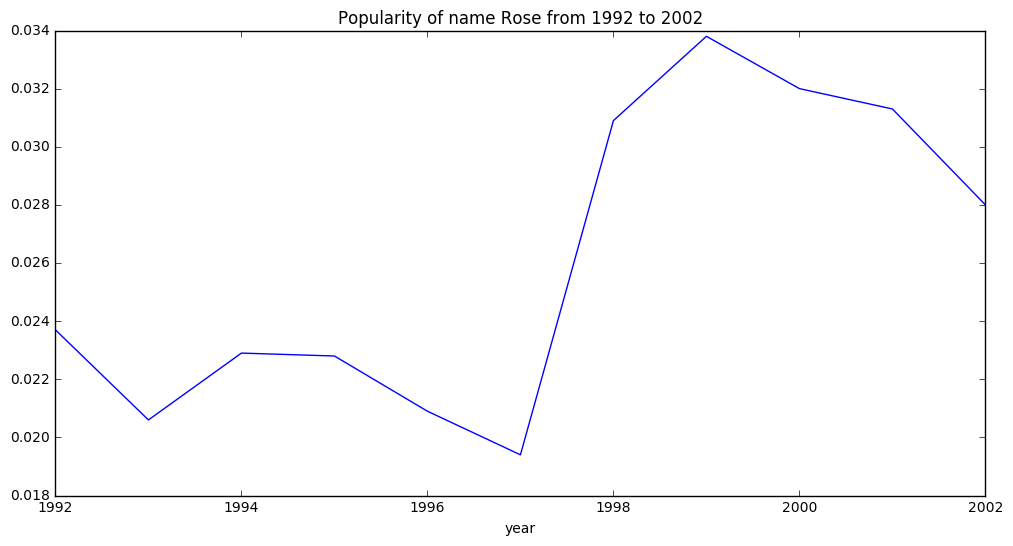

In [39]:
s.NamePopularityPlot(name = "Rose", yearRange=(1992,2002))

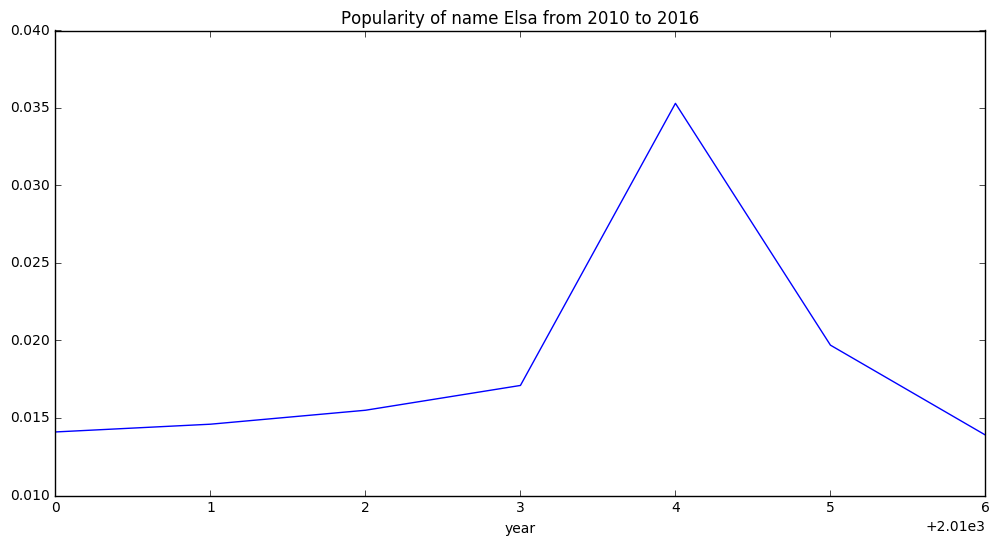

In [38]:
s.NamePopularityPlot(name = "Elsa", yearRange=(2010,2016))

For both films, the increase in popularity was shortlived, lasting only a couple years after the film's release.